# Pricing Options using Finite Differenences method, and Implied Volatility
## Zach Barnhart

### First we copy all our results from the first and second part. Some of the classes we have built can easily be modified for our goals listed above. Skip to NEW STUFF HERE to get to the new stuff for this part

## StockOption base class

In [1]:
import math

# The basic stock option class that will serve as the basis for more specific subclasses
# Contains all the basic attibutes and methods common to all options
class StockOption(object):
    def __init__(self, s_0, K, r=0.04, T=1, N=2, pu=0, pd=0, div=0, sigma=0, is_put=False, is_am=False):
        
        self.s_0 = s_0
        self.K = K
        self.r = r
        self.T = T
        self.N = max(1, N)
        self.STs = [] # Declare the stock prices tree

        # will use these for certain classes later
        self.pu, self.pd = pu, pd
        self.div = div
        self.sigma = sigma
        self.is_call = not is_put
        self.is_european = not is_am

    @property
    def dt(self):
        return self.T / float(self.N)

    @property
    def df(self):
        return math.exp(-(self.r-self.div)*self.dt)  

## European options using a binomial tree

In [2]:
import numpy as np
from decimal import Decimal

# Price a basic European option using the binomial tree model 
class BinomialEuropeanOption(StockOption):

    def setup_parameters(self):
        # Required calculations for the model
        self.M = self.N + 1  # Number of terminal nodes of tree
        self.u = 1 + self.pu  # Expected value in the up state
        self.d = 1 - self.pd  # Expected value in the down state
        self.qu = (math.exp((self.r-self.div)*self.dt)-self.d)/(self.u-self.d)
        self.qd = 1 - self.qu

    def init_underlying_price_tree(self):
        # Initialize terminal price nodes to zeros
        self.STs = np.zeros(self.M)

        # Calculate expected stock prices for each node
        for i in range(self.M):
            self.STs[i] = self.s_0 * (self.u**(self.N-i)) * (self.d**i)

    def init_payoffs_tree(self):
        
        if self.is_call:
            return np.maximum(0, self.STs - self.K)
        else:
            return np.maximum(0, self.K - self.STs)

    def calculate_payoffs(self, payoffs):
        
        for i in range(self.N):
            payoffs = (payoffs[:-1] * self.qu + payoffs[1:] * self.qd) * self.df

        return payoffs

    def begin_tree_traversal(self):
        payoffs = self.init_payoffs_tree()
        return self.calculate_payoffs(payoffs)

    def price(self):
        self.setup_parameters()
        self.init_underlying_price_tree()
        payoffs = self.begin_tree_traversal()

        # Option value converges to first node
        return payoffs[0]

In [3]:
BinomialEuropeanOption(30, 55, r=0.04, T=2, N=2, pu=0.2, pd=0.2, is_put=True).price()

20.771399051264964

## American options using a binomial tree
### (Class can handle both types)

In [4]:
#Price a European or American option by the binomial tree 

class BinomialTreeOption(StockOption):

    def setup_parameters(self):
        self.u = 1 + self.pu  # Expected value in the up state
        self.d = 1 - self.pd  # Expected value in the down state
        self.qu = (math.exp((self.r - self.div) *  self.dt) - self.d) / (self.u - self.d)
        self.qd = 1 - self.qu

    def init_underlying_price_tree(self):
        # Initialize a tree to add to
        self.STs = [np.array([self.s_0])]

        # Simulate the possible stock prices path
        for i in range(self.N):
            prev_branches = self.STs[-1]
            st = np.concatenate((prev_branches * self.u, [prev_branches[-1] * self.d]))
            self.STs.append(st) # Add nodes at each time step

    def init_payoffs_tree(self):
        if self.is_call:
            return np.maximum(0, self.STs[self.N] - self.K)
        else:
            return np.maximum(0, self.K - self.STs[self.N])

    def check_early_exercise(self, payoffs, node):
        if self.is_call:
            return np.maximum(payoffs, self.STs[node] - self.K)
        else:
            return np.maximum(payoffs, self.K - self.STs[node])

    def calculate_payoffs(self, payoffs):
        for i in reversed(range(self.N)):
            # The payoffs from NOT exercising the option
            payoffs = (payoffs[:-1] * self.qu + payoffs[1:] * self.qd) * self.df

            # Payoffs from exercising, for American options
            if not self.is_european:
                payoffs = self.check_early_exercise(payoffs, i)

        return payoffs

    def begin_tree_traversal(self):
        payoffs = self.init_payoffs_tree()
        return self.calculate_payoffs(payoffs)

    def price(self):
        self.setup_parameters()
        self.init_underlying_price_tree()
        payoffs = self.begin_tree_traversal()
        return payoffs[0]

In [5]:
BinomialTreeOption(50, 52, r=0.04, T=2, N=200, pu=0.2, pd=0.2, is_put=True, is_am=True).price()

41.71188633590327

## The Cox-Ross-Rubinstein model

### A class for Cox-Ross-Rubinstein binomial tree option pricing model

In [6]:
# Price an option by the binomial CRR model 
class BinomialCRROption(BinomialTreeOption):
    def setup_parameters(self):
        self.u = math.exp(self.sigma * math.sqrt(self.dt))
        self.d = 1. / self.u
        self.qu = (math.exp((self.r - self.div) * self.dt) - self.d) / (self.u - self.d)
        self.qd = 1 - self.qu

In [7]:
BinomialCRROption(50, 52, r=0.04, T=0.5, N=1008, sigma=0.3, is_put=True).price()

4.766499908855962

## Using a Leisen-Reimer (LR) tree

### A class for LR binomial tree option pricing model

In [8]:
# Price an option by the Leisen-Reimer model
class BinomialLROption(BinomialTreeOption):

    def setup_parameters(self):
        odd_N = self.N if (self.N % 2 == 0) else (self.N + 1)
        d1 = (math.log(self.s_0 / self.K) + ((self.r-self.div) + (self.sigma**2) / 2.) * self.T)/ (self.sigma * math.sqrt(self.T))
        d2 = (math.log(self.s_0 / self.K) +((self.r - self.div) - (self.sigma**2) / 2.) * self.T) / (self.sigma * math.sqrt(self.T))

        pbar = self.pp_2_inversion(d1, odd_N)
        self.p = self.pp_2_inversion(d2, odd_N)
        self.u = 1 / self.df * pbar / self.p
        self.d = (1 / self.df - self.p * self.u) / (1 - self.p)
        self.qu = self.p
        self.qd = 1 - self.p

    def pp_2_inversion(self, z, n):
        return .5 + math.copysign(1, z) * math.sqrt(.25 - .25 * math.exp(-((z / (n + 1./3. + .1/(n+1)))**2.) * (n+1./6.)))

In [9]:
BinomialLROption(30, 52, r=0.04, T=0.5, N=1008, sigma=0.3, is_put=True).price()

20.986880225025804

### Black-Scholes Formula

In [10]:
from scipy.stats import norm

def black_scholes_analytical(S_0, K, T, r, sigma, is_put=False):
    
    d1 = (np.log(S_0 / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = (np.log(S_0 / K) + (r - 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    
    if not is_put:
        val = (S_0 * norm.cdf(d1, 0, 1) - K * np.exp(-r * T) * norm.cdf(d2, 0, 1))
    else:
        val = (K * np.exp(-r * T) * norm.cdf(-d2, 0, 1) - S_0 * norm.cdf(-d1, 0, 1))
        
    return val

In [11]:
black_scholes_analytical(S_0=10,K=52,T=0.5,r=0.04, sigma=0.3, is_put=True)

40.97033101195128

In [12]:
BinomialCRROption(180, 52, r=0.04, T=0.5, N=1008, sigma=2, is_put=True).price()

11.858479856107131

In [13]:
BinomialLROption(180, 52, r=0.04, T=0.5, N=1008, sigma=2, is_put=True).price()

11.851464583868397

In [14]:
black_scholes_analytical(S_0=180,K=52,T=0.5,r=0.04, sigma=2, is_put=True)

11.865099031024723

## Produce American vs. European graphs

In [15]:
def putValue(s_0, K):
    return np.maximum(K-s_0, 0)

def callValue(s_0, K):
    return np.maximum(s_0-K, 0)

In [16]:
x = np.linspace(0.00000000001,60,1000)

In [17]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

In [18]:
y_euc = [BinomialLROption(i, 32, r=0.04, T=0.5, N=1008, sigma=0.3, is_put=True).price() for i in x]

In [19]:
y_amc = [BinomialLROption(i, 32, r=0.04, T=0.5, N=1008, sigma=0.3, is_put=True, is_am=True).price() for i in x]

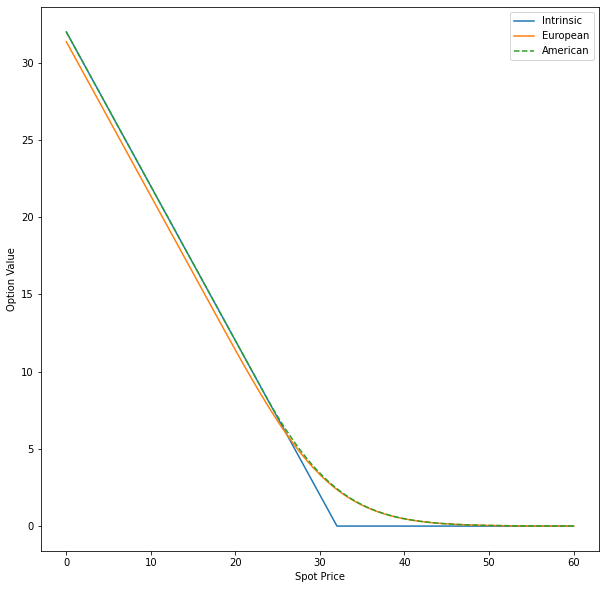

In [20]:
figure(figsize=(10,10))
plt.plot(x,putValue(s_0=x,K=32), label="Intrinsic")
plt.plot(x,y_euc, label="European")
plt.plot(x,y_amc, label="American", ls="--")
plt.legend()
plt.xlabel("Spot Price")
plt.ylabel("Option Value")
plt.savefig("puts.png")
plt.show()

In [21]:
x = np.linspace(0.00000000001,60,1000)

In [22]:
y_eup = [BinomialLROption(i, 32, r=0.04, T=0.5, N=1008, sigma=0.3, is_put=False).price() for i in x]

In [23]:
y_amp = [BinomialLROption(i, 32, r=0.04, T=0.5, N=1008, sigma=0.3, is_put=False, is_am=True).price() for i in x]

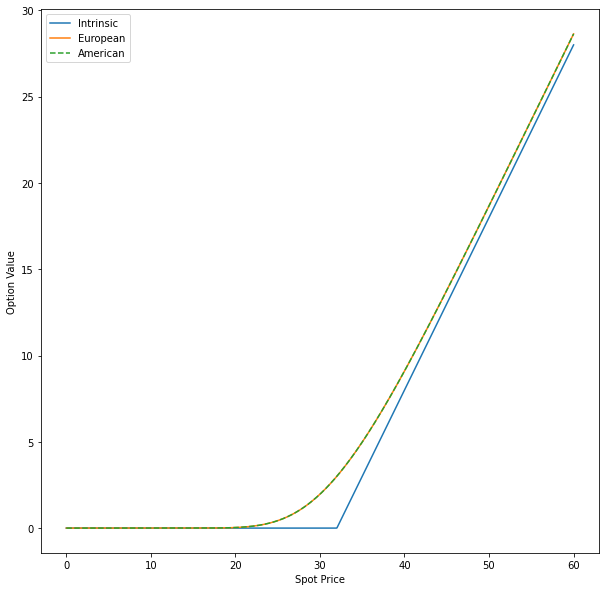

In [24]:
figure(figsize=(10,10))
plt.plot(x,callValue(s_0=x,K=32), label="Intrinsic")
plt.plot(x,y_eup, label="European")
plt.plot(x,y_amp, label="American", ls="--")
plt.legend()
plt.xlabel("Spot Price")
plt.ylabel("Option Value")
plt.savefig("calls.png")
plt.show()

# NEW STUFF FOR PART 2 FROM HERE ONWARD

# Trinomial Trees

In [25]:
class TrinomialTreeOption(BinomialTreeOption):

    def setup_parameters(self):
        self.u = math.exp(self.sigma*math.sqrt(2.*self.dt))
        self.d = 1/self.u
        self.m = 1
        self.qu = ((math.exp((self.r-self.div) * self.dt/2.) - math.exp(-self.sigma * math.sqrt(self.dt/2.))) /
                   (math.exp(self.sigma * math.sqrt(self.dt/2.)) - math.exp(-self.sigma * math.sqrt(self.dt/2.))))**2
        self.qd = ((math.exp(self.sigma * math.sqrt(self.dt/2.)) - math.exp((self.r-self.div) * self.dt/2.)) /
                   (math.exp(self.sigma * math.sqrt(self.dt/2.)) - math.exp(-self.sigma * math.sqrt(self.dt/2.))))**2
        self.qm = 1 - self.qu - self.qd

    def init_underlying_price_tree(self):
        # Initialize a 2D tree to add to
        self.STs = [np.array([self.s_0])]

        for i in range(self.N):
            prev_nodes = self.STs[-1]
            self.ST = np.concatenate((prev_nodes * self.u, [prev_nodes[-1] * self.m, prev_nodes[-1] * self.d]))
            self.STs.append(self.ST)

    def calculate_payoffs(self, payoffs):
        # Traverse the tree backwards 
        for i in reversed(range(self.N)):
            payoffs = (payoffs[:-2] * self.qu + payoffs[1:-1] * self.qm + payoffs[2:] * self.qd) * self.df

            if not self.is_european:
                payoffs = self.check_early_exercise(payoffs, i)

        return payoffs

In [26]:
eu_put = TrinomialTreeOption(50, 52, r=0.05, T=2, N=2, sigma=0.3, is_put=True)

In [27]:
print('European put:', eu_put.price())

European put: 6.573565269142496


In [28]:
am_option = TrinomialTreeOption(50, 52, r=0.05, T=2, N=2, sigma=0.3, is_put=True, is_am=True)

In [29]:
print('American put:', am_option.price())

American put: 7.161349217272585


## Generating a table of trinomial option prices

In [30]:
prices = [10, 30, 50, 70, 90]
is_put = [False, True]
is_am = [False, True]

In [31]:
import pandas as pd

rows_list = []
for style in is_am:
    for opt_type in is_put:
        row = {}
        row['is_am']=style
        row['is_put']=opt_type
        for price in prices:
            col = str(price)
            row[col] = BinomialCRROption(price, 52, r=0.04, T=0.5, N=6, sigma=1, is_put=opt_type, is_am=style).price()
        rows_list.append(row)
        
        
opt_prices = pd.DataFrame(rows_list)

In [32]:
opt_prices

,is_am,is_put,10,30,50,70,90
0,False,False,0.029635,3.225469,13.174447,28.354095,44.114929
1,False,True,40.999966,24.195800,14.144778,9.324426,5.085260
2,True,False,0.029635,3.225469,13.174447,28.354095,44.114929
3,True,True,42.000000,24.526709,14.353000,9.389724,5.150558


In [33]:
rows_list = []
for style in is_am:
    for opt_type in is_put:
        row = {}
        row['is_am']=style
        row['is_put']=opt_type
        for price in prices:
            col = str(price)
            row[col] = TrinomialTreeOption(price, 52, r=0.04, T=0.5, N=6, sigma=1, is_put=opt_type, is_am=style).price()
        rows_list.append(row)
        
        
opt_prices_tri = pd.DataFrame(rows_list)

In [34]:
opt_prices_tri

,is_am,is_put,10,30,50,70,90
0,False,False,0.031336,3.580736,13.372588,27.964310,44.674664
1,False,True,41.001667,24.551067,14.342919,8.934641,5.644995
2,True,False,0.031336,3.580736,13.372588,27.964310,44.674664
3,True,True,42.000000,24.820136,14.470768,8.990804,5.662706


In [35]:
rows_list = []
for opt_type in is_put:
    row = {}
    row['is_put']=opt_type
    for price in prices:
        col = str(price)
        row[col] = black_scholes_analytical(price, K=52, r=0.04, T=0.5, sigma=1, is_put=opt_type)
    rows_list.append(row)
        
        
opt_prices_bs = pd.DataFrame(rows_list)

In [36]:
opt_prices_bs

,is_put,10,30,50,70,90
0,False,0.055021,3.501070,13.470160,27.798794,44.538811
1,True,41.025352,24.471401,14.440491,8.769125,5.509142


In [37]:
is_tri = [False, True]
N_steps = [6, 126, 252, 1008]

In [38]:
rows_list = []
for price in prices:
    for bt in is_tri:
        row = {}
        row['price'] = price
        row['is_tri']=bt
        for N_step in N_steps:
            col = str(N_step)
            if bt:
                row[col] = TrinomialTreeOption(price, 52, r=0.04, T=0.5, N=N_step, sigma=1, is_put=False, is_am=True).price()
            else:
                row[col] = BinomialCRROption(price, 52, r=0.04, T=0.5, N=N_step, sigma=1, is_put=False, is_am=True).price()
        rows_list.append(row)
        
        
opt_prices_btcall = pd.DataFrame(rows_list)

In [39]:
opt_prices_btcall

,price,is_tri,6,126,252,1008
0,10,False,0.029635,0.053063,0.054643,0.054727
1,10,True,0.031336,0.054643,0.054642,0.054962
2,30,False,3.225469,3.510016,3.500052,3.502136
3,30,True,3.580736,3.500052,3.502343,3.501777
4,50,False,13.174447,13.487939,13.482459,13.469489
5,50,True,13.372588,13.482459,13.475704,13.470883
6,70,False,28.354095,27.819679,27.808485,27.801180
7,70,True,27.964310,27.808485,27.802581,27.800344
8,90,False,44.114929,44.553680,44.536355,44.540383
9,90,True,44.674664,44.536355,44.541655,44.539958


In [40]:
rows_list = []
for price in prices:
    for bt in is_tri:
        row = {}
        row['price'] = price
        row['is_tri']=bt
        for N_step in N_steps:
            col = str(N_step)
            if bt:
                row[col] = TrinomialTreeOption(price, 52, r=0.04, T=0.5, N=N_step, sigma=1, is_put=True, is_am=True).price()
            else:
                row[col] = BinomialCRROption(price, 52, r=0.04, T=0.5, N=N_step, sigma=1, is_put=True, is_am=True).price()
        rows_list.append(row)
        
        
opt_prices_btput = pd.DataFrame(rows_list)

In [41]:
opt_prices_btput

,price,is_tri,6,126,252,1008
0,10,False,42.000000,42.000000,42.000000,42.000000
1,10,True,42.000000,42.000000,42.000000,42.000000
2,30,False,24.526709,24.758291,24.748179,24.748545
3,30,True,24.820136,24.746953,24.748406,24.747885
4,50,False,14.353000,14.568609,14.561265,14.547684
5,50,True,14.470768,14.560277,14.553444,14.548756
6,70,False,9.389724,8.841586,8.829926,8.822249
7,70,True,8.990804,8.829221,8.823644,8.821150
8,90,False,5.150558,5.551290,5.533711,5.537317
9,90,True,5.662706,5.533219,5.538660,5.536762


# Monte Carlo Simulations

### Define European option simulator and value calculator as discussed in report

In [42]:
def european_option_simulation(S_0, K, T, r, sigma, n_sims, is_put):

    rv = np.random.normal(0, 1, size=n_sims)
    S_T = S_0 * np.exp((r - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * rv)

    if is_put:
        payoff = np.maximum(0, K - S_T)
    else:
        payoff = np.maximum(0, S_T - K)
        
    premium = np.mean(payoff) * np.exp(-r * T)
    return premium

In [43]:
prices = [10, 30, 50, 70, 90]
is_put = [False, True]

In [44]:
european_option_simulation(S_0=50, K=52, T=0.5, r=0.04, sigma=1, n_sims=10000000, is_put=True)

14.436497569739437

In [45]:
rows_list = []
for opt_type in is_put:
    row = {}
    row['is_put']=opt_type
    for price in prices:
        col = str(price)
        row[col] = european_option_simulation(price, K=52, r=0.04, T=0.5, sigma=1, n_sims=1000000, is_put=opt_type)
    rows_list.append(row)
        
        
opt_prices_mc = pd.DataFrame(rows_list)

In [46]:
opt_prices_mc

,is_put,10,30,50,70,90
0,False,0.052700,3.482699,13.427963,27.932313,44.564037
1,True,41.028082,24.481549,14.452368,8.778316,5.524531


## Do the same for American option

### This time, we need the whole path of the of price of the underlying to take into account the possibility of early exercise. For this we make a support function to generate underlying paths

In [47]:
def simulate_gbm(S_0, mu, sigma,  T, N, n_sims):

    dt = T/N
    dW = np.random.normal(scale=np.sqrt(dt),size=(n_sims, N + 1))
    S_t = S_0 * np.exp(np.cumsum((mu - 0.5 * sigma ** 2) * dt + sigma * dW,axis=1))
    S_t[:, 0] = S_0

    return S_t

In [48]:
def lsmc_american_option(S_0, K, T, N, r, sigma, is_put, poly_degree, n_sims):
    
    dt = T / N
    discount_factor = np.exp(-r * dt)

    gbm_simulations = simulate_gbm(S_0=S_0, mu=r, sigma=sigma, n_sims=n_sims, T=T, N=N,)

    if is_put:
        payoff_matrix = np.maximum(K - gbm_simulations, np.zeros_like(gbm_simulations))
    else:
        payoff_matrix = np.maximum(gbm_simulations - K, np.zeros_like(gbm_simulations))
    
    value_matrix = np.zeros_like(payoff_matrix)
    value_matrix[:, -1] = payoff_matrix[:, -1]

    for t in range(N - 1, 0, -1):
        regression = np.polyfit(gbm_simulations[:, t], value_matrix[:, t + 1] * discount_factor, poly_degree)
        continuation_value = np.polyval(regression, gbm_simulations[:, t])
        value_matrix[:, t] = np.where(payoff_matrix[:, t] > continuation_value, payoff_matrix[:, t], value_matrix[:, t + 1] * discount_factor)

    option_premium = np.mean(value_matrix[:, 1] * discount_factor)
    return option_premium

In [49]:
# N_SIMS 10000 takes a handful of seconds, N_SIMS 100000 takes a few minutes, N_SIMS 1000000 takes more than two hours
N_SIMS = 100000
N_steps = [6, 126, 252, 1008]
prices = [10, 30, 50, 70, 90]

In [50]:
rows_list = []
for price in prices:
    row = {}
    row['price'] = price
    for N_step in N_steps:
        col = str(N_step)
        row[col] = lsmc_american_option(price, 52, r=0.04, T=0.5, N=N_step, sigma=1, poly_degree=5, n_sims=N_SIMS, is_put=True)
    
    rows_list.append(row)
        
        
opt_prices_lsmc = pd.DataFrame(rows_list)

In [51]:
opt_prices_lsmc

,price,6,126,252,1008
0,10,41.854659,41.990883,41.992927,41.999558
1,30,25.323639,24.574165,24.504287,24.579356
2,50,15.473008,14.218419,14.182684,14.083370
3,70,9.671019,8.322857,8.288023,8.158809
4,90,6.385099,4.932022,4.873794,4.708622


In [52]:
opt_prices_lsmc_put_100000 = opt_prices_lsmc

In [53]:
opt_prices_lsmc_call_100000

NameError: name 'opt_prices_lsmc_call_100000' is not defined

In [54]:
opt_prices_lsmc_put_100000

,price,6,126,252,1008
0,10,41.854659,41.990883,41.992927,41.999558
1,30,25.323639,24.574165,24.504287,24.579356
2,50,15.473008,14.218419,14.182684,14.083370
3,70,9.671019,8.322857,8.288023,8.158809
4,90,6.385099,4.932022,4.873794,4.708622


# NEW STUFF FROM HERE ON

# FINITE DIFFERENCES

### First we write our base FiniteDifferences abstract class from which the explicit, implicit, and Crank-Nicolson methods will be derived

In [55]:
from abc import ABC, abstractmethod

class FiniteDifferences(object):

    def __init__(self, S0, K, r=0.05, T=1, sigma=0, Smax=1, M=1, N=1, is_put=False):
        self.S0 = S0
        self.K = K
        self.r = r
        self.T = T
        self.sigma = sigma
        self.Smax = Smax
        self.M, self.N = M, N
        self.is_call = not is_put

        self.i_values = np.arange(self.M)
        self.j_values = np.arange(self.N)
        self.grid = np.zeros(shape=(self.M+1, self.N+1))
        self.boundary_conds = np.linspace(0, Smax, self.M+1)

    @property
    def dS(self):
        return self.Smax/float(self.M)

    @property
    def dt(self):
        return self.T/float(self.N)

    @abstractmethod
    def setup_boundary_conditions(self):
        raise NotImplementedError('Implementation required!')

    @abstractmethod
    def setup_coefficients(self):
        raise NotImplementedError('Implementation required!')
         
    @abstractmethod
    def traverse_grid(self):
        # pass it along
        raise NotImplementedError('Implementation required!')

    @abstractmethod
    def interpolate(self):
        # in case s0 not on grid, must interpolte
        return np.interp(self.S0, self.boundary_conds, self.grid[:,0])

    def price(self):
        self.setup_boundary_conditions()
        self.setup_coefficients()
        self.traverse_grid()
        return self.interpolate()

### First, the explicit method

In [56]:
class FDExplicitEu(FiniteDifferences):

    def setup_boundary_conditions(self):
        if self.is_call:
            self.grid[:,-1] = np.maximum(0, self.boundary_conds - self.K)
            self.grid[-1,:-1] = (self.Smax - self.K) * np.exp(-self.r * self.dt * (self.N - self.j_values))
        else:
            self.grid[:,-1] = np.maximum(0, self.K - self.boundary_conds)
            self.grid[0,:-1] = (self.K - self.Smax) * np.exp(-self.r * self.dt * (self.N - self.j_values))

    def setup_coefficients(self):
        self.a = 0.5*self.dt*((self.sigma**2) * (self.i_values**2) - self.r*self.i_values)
        self.b = 1 - self.dt*((self.sigma**2) * (self.i_values**2) + self.r)
        self.c = 0.5*self.dt*((self.sigma**2) * (self.i_values**2) + self.r*self.i_values)

    def traverse_grid(self):
        for j in reversed(self.j_values):
            for i in range(self.M)[2:]:
                self.grid[i,j] = self.a[i] * self.grid[i-1,j+1] + self.b[i] * self.grid[i,j+1] + self.c[i] * self.grid[i+1,j+1]

In [57]:
import pandas as pd

rows_list = []
for opt_type in is_put:
    row = {}
    row['is_put']=opt_type
    for price in prices:
        col = str(price)
        row[col] = FDExplicitEu(price, K=52, r=0.04, T=0.5, sigma=0.3, Smax=100, M=100, N=1008, is_put=opt_type).price()
    rows_list.append(row)
        
        
opt_prices_fdexp = pd.DataFrame(rows_list)

In [58]:
opt_prices_fdexp

,is_put,10,30,50,70,90
0,False,4.628250e-13,0.016859,3.792571,19.3479,38.216826
1,True,4.097032e+01,20.987180,4.763167,0.3729,0.015708


### Now, the implicit method

In [59]:
import scipy.linalg as linalg

class FDImplicitEu(FDExplicitEu):

    def setup_coefficients(self):
        self.a = 0.5*(self.r*self.dt*self.i_values - (self.sigma**2)*self.dt* (self.i_values**2))
        self.b = 1 + (self.sigma**2)*self.dt * (self.i_values**2) + self.r*self.dt
        self.c = -0.5*(self.r*self.dt*self.i_values + (self.sigma**2)*self.dt* (self.i_values**2))
        self.coeffs = np.diag(self.a[2:self.M],-1) + np.diag(self.b[1:self.M]) + np.diag(self.c[1:self.M-1],1)

    def traverse_grid(self):
        # Solve using LU factorization
        P, L, U = linalg.lu(self.coeffs)
        aux = np.zeros(self.M-1)

        for j in reversed(range(self.N)):
            aux[0] = np.dot(-self.a[1], self.grid[0, j])
            x1 = linalg.solve(L, self.grid[1:self.M, j+1]+aux)
            x2 = linalg.solve(U, x1)
            self.grid[1:self.M, j] = x2

In [60]:
import pandas as pd

rows_list = []
for opt_type in is_put:
    row = {}
    row['is_put']=opt_type
    for price in prices:
        col = str(price)
        row[col] = FDImplicitEu(price, K=52, r=0.04, T=0.5, sigma=0.3, Smax=200, M=500, N=1008, is_put=opt_type).price()
    rows_list.append(row)
        
        
opt_prices_fdimp5 = pd.DataFrame(rows_list)

In [61]:
# M=1000
opt_prices_fdimp

NameError: name 'opt_prices_fdimp' is not defined

In [ ]:
# M=100
opt_prices_fdimp2

In [ ]:
# sigma = 1
opt_prices_fdimp3

In [ ]:
# smax = 200
opt_prices_fdimp4

In [62]:
# smax=200 and M=500
opt_prices_fdimp5

,is_put,10,30,50,70,90
0,False,2.464660e-14,0.016783,3.795524,19.403211,39.022171
1,True,4.097034e+01,20.987124,4.765865,0.373662,0.016283


### Lastly, the Crank-Nicolson Method

In [63]:
class FDCnEu(FDExplicitEu):

    def setup_coefficients(self):
        self.alpha = 0.25*self.dt*((self.sigma**2)*(self.i_values**2) - self.r*self.i_values)
        self.beta = -self.dt*0.5*((self.sigma**2)*(self.i_values**2) + self.r)
        self.gamma = 0.25*self.dt*((self.sigma**2)*(self.i_values**2) + self.r*self.i_values)
        self.M1 = -np.diag(self.alpha[2:self.M], -1) + np.diag(1-self.beta[1:self.M]) - np.diag(self.gamma[1:self.M-1], 1)
        self.M2 = np.diag(self.alpha[2:self.M], -1) + np.diag(1+self.beta[1:self.M]) + np.diag(self.gamma[1:self.M-1], 1)

    def traverse_grid(self):
        # again, solve using LU factorization
        P, L, U = linalg.lu(self.M1)

        for j in reversed(range(self.N)):
            x1 = linalg.solve(L, np.dot(self.M2, self.grid[1:self.M, j+1]))
            x2 = linalg.solve(U, x1)
            self.grid[1:self.M, j] = x2

In [64]:
rows_list = []
for opt_type in is_put:
    row = {}
    row['is_put']=opt_type
    for price in prices:
        col = str(price)
        row[col] = FDCnEu(price, K=52, r=0.04, T=0.5, sigma=0.3, Smax=200, M=500, N=1008, is_put=opt_type).price()
    rows_list.append(row)
        
        
opt_prices_fdcn = pd.DataFrame(rows_list)

In [65]:
opt_prices_fdcn

,is_put,10,30,50,70,90
0,False,1.722585e-14,0.016673,3.796039,19.403094,39.022564
1,True,4.097033e+01,20.987004,4.766370,0.373528,0.016183


### Using CN with Exotic Down-and-Out Barrier Option

In [66]:
class FDCnDo(FDCnEu):

    def __init__(self, S0, K, r=0.05, T=1, sigma=0, Sbarrier=0, Smax=1, M=1, N=1, is_put=False):
        
        super(FDCnDo, self).__init__(S0, K, r=r, T=T, sigma=sigma, Smax=Smax, M=M, N=N, is_put=is_put)
        self.barrier = Sbarrier
        self.boundary_conds = np.linspace(Sbarrier, Smax, M+1)
        self.i_values = self.boundary_conds/self.dS

    @property
    def dS(self):
        return (self.Smax-self.barrier)/float(self.M)

In [67]:
FDCnDo(50, 52, r=0.04, T=0.5, sigma=0.3, Sbarrier=40, Smax=200, M=500, N=1008).price()

3.7535773861314565

In [68]:
FDCnDo(30, 52, r=0.04, T=0.5, sigma=0.3, Sbarrier=40, Smax=200, M=500, N=1008).price()

0.0

In [69]:
FDCnDo(41, 52, r=0.04, T=0.5, sigma=0.3, Sbarrier=40, Smax=200, M=500, N=1008).price()

0.29654584821748015

In [70]:
FDCnEu(41, K=52, r=0.04, T=0.5, sigma=0.3, Smax=200, M=500, N=1008).price()

0.7661484894137863

In [71]:
FDCnDo(44, 52, r=0.04, T=0.5, sigma=0.3, Sbarrier=40, Smax=200, M=500, N=1008).price()

1.2297043247782633

In [72]:
FDCnEu(44, K=52, r=0.04, T=0.5, sigma=0.3, Smax=200, M=500, N=1008).price()

1.4468621261308718

### FD CN modified for American Options

In [73]:
import sys

class FDCnAm(FDCnEu):

    def __init__(self, S0, K, r=0.05, T=1, sigma=0, Smax=1, M=1, N=1, omega=1, tol=0, is_put=False):
        super(FDCnAm, self).__init__(S0, K, r=r, T=T, sigma=sigma, Smax=Smax, M=M, N=N, is_put=is_put)
        self.omega = omega
        self.tol = tol
        self.i_values = np.arange(self.M+1)
        self.j_values = np.arange(self.N+1)

    def setup_boundary_conditions(self):
        if self.is_call:
            self.payoffs = np.maximum(0, self.boundary_conds[1:self.M]-self.K)
        else:
            self.payoffs = np.maximum(0, self.K-self.boundary_conds[1:self.M])

        self.past_values = self.payoffs
        self.boundary_values = self.K * np.exp(-self.r*self.dt*(self.N-self.j_values))
        
    def calculate_payoff_start_boundary(self, rhs, old_values):
        payoff = old_values[0] + self.omega/(1-self.beta[1]) * (rhs[0] - (1-self.beta[1])*old_values[0] + self.gamma[1]*old_values[1])

        return max(self.payoffs[0], payoff)      
    
    def calculate_payoff_end_boundary(self, rhs, old_values, new_values):
        payoff = old_values[-1] + self.omega/(1-self.beta[-2]) * (rhs[-1] + self.alpha[-2]*new_values[-2] - (1-self.beta[-2])*old_values[-1])

        return max(self.payoffs[-1], payoff)
    
    def calculate_payoff(self, k, rhs, old_values, new_values):
        payoff = old_values[k] + self.omega/(1-self.beta[k+1]) * (rhs[k] + self.alpha[k+1]*new_values[k-1] - (1-self.beta[k+1])*old_values[k] + self.gamma[k+1]*old_values[k+1])

        return max(self.payoffs[k], payoff)

    def traverse_grid(self):
        aux = np.zeros(self.M-1)
        new_values = np.zeros(self.M-1)

        for j in reversed(range(self.N)):
            aux[0] = self.alpha[1]*(self.boundary_values[j] + self.boundary_values[j+1])
            rhs = np.dot(self.M2, self.past_values) + aux
            old_values = np.copy(self.past_values)
            error = sys.float_info.max

            while self.tol < error:
                new_values[0] = self.calculate_payoff_start_boundary(rhs, old_values)            

                for k in range(self.M-2)[1:]:
                    new_values[k] = self.calculate_payoff(k, rhs, old_values, new_values)                    

                new_values[-1] = self.calculate_payoff_end_boundary(rhs, old_values, new_values)

                error = np.linalg.norm(new_values-old_values)
                old_values = np.copy(new_values)

                self.past_values = np.copy(new_values)

        self.values = np.concatenate(([self.boundary_values[0]], new_values, [0]))

    def interpolate(self):
        # Use linear interpolation on final values as 1D array
        return np.interp(self.S0, self.boundary_conds, self.values)

In [74]:
rows_list = []
for price in prices:
    row = {}
    row['price'] = price
    row[col] = FDCnAm(price, 52, r=0.04, T=0.5, Smax=200, omega=1.2, tol=0.001, sigma=1, N=1008, M=500).price()
    
    rows_list.append(row)
        
        
opt_prices_fdcnam = pd.DataFrame(rows_list)

In [75]:
opt_prices_fdcnam

,price,90
0,10,0.055278
1,30,3.492209
2,50,13.424430
3,70,27.673480
4,90,44.283654


In [76]:
rows_list = []
for price in prices:
    row = {}
    row['price'] = price
    row[col] = FDCnAm(price, 52, r=0.04, T=0.5, Smax=200, omega=1.2, tol=0.001, sigma=1, N=1008, M=500, is_put=True).price()
    
    rows_list.append(row)
        
        
opt_prices_fdcnam_put = pd.DataFrame(rows_list)

In [77]:
opt_prices_fdcnam_put

,price,90
0,10,42.000000
1,30,24.738905
2,50,14.510432
3,70,8.728305
4,90,5.368146


# Implied Volatility

In [78]:
class ImpliedVolatilityModel(object):

    def __init__(self, s_0, r=0.05, T=1, div=0, N=1, is_put=False):
        self.s_0 = s_0
        self.r = r
        self.T = T
        self.div = div
        self.N = N
        self.is_put = is_put

    def option_valuation(self, K, sigma):
        lr_option = BinomialLROption(self.s_0, K, r=self.r, T=self.T, N=self.N, sigma=sigma, div=self.div, is_put=self.is_put)
        return lr_option.price()

    def get_implied_volatilities(self, Ks, opt_prices):
        impvols = []
        for i in range(len(strikes)):
            f = lambda sigma: self.option_valuation(Ks[i], sigma)- opt_prices[i]
            impv = bisection(f, 0.01, 0.99, 0.0001, 100)[0]
            impvols.append(impv)

        return impvols

In [79]:
def bisection(f, a, b, tol=0.1, maxiter=100):
    c = (a+b)*0.5 
    n = 1 
    while n <= maxiter:
        c = (a+b)*0.5
        if f(c) == 0 or abs(a-b)*0.5 < tol:
            return c, n

        n += 1
        if f(c) < 0:
            a = c
        else:
            b = c
                
    return c, n

In [80]:
import pandas as pd
df = pd.read_csv("https://raw.githubusercontent.com/ZachNJIT/data/main/spy_options.csv")

In [81]:
cols = []
for col in df.columns:
    col = col.strip()
    cols.append(col)

In [82]:
df['date'].unique()

array(['2015-01-05'], dtype=object)

In [83]:
df.columns = cols
cols

['date',
 'symbol',
 'under',
 'expiration',
 'strike',
 'put/call',
 'bid',
 'ask',
 'price',
 'volume',
 'open interest',
 'implied vol',
 'delta',
 'gamma',
 'rho',
 'theta',
 'vega',
 'nonstd']

In [84]:
df['expiration'].unique()

array(['2015-01-02', '2015-01-09', '2015-01-17', '2015-01-23',
       '2015-01-30', '2015-02-06', '2015-02-13', '2015-02-20',
       '2015-03-20', '2015-03-31', '2015-04-17', '2015-06-19',
       '2015-06-30', '2015-09-18', '2015-09-30', '2015-12-19',
       '2015-12-31', '2016-01-15', '2016-03-18', '2016-06-17',
       '2016-09-16', '2016-12-16', '2017-01-20', '2017-12-15'],
      dtype=object)

In [85]:
T_3 = df[df['expiration']=='2015-04-17']

In [86]:
T3P = T_3[T_3['put/call']=='P']

In [87]:
T3P = T3P[T3P['price']>0]

In [88]:
strikes = T3P['strike'].tolist()

In [89]:
put_prices = T3P['price'].tolist()

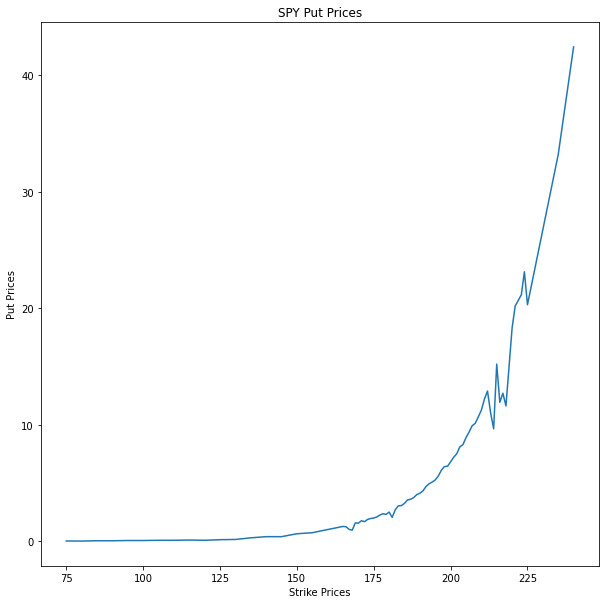

In [90]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

figure(figsize=(10,10))
plt.plot(strikes, put_prices)
plt.xlabel('Strike Prices')
plt.ylabel('Put Prices')
plt.title('SPY Put Prices')
plt.show()

In [91]:
S0 = 195
model = ImpliedVolatilityModel(S0, r=0.02, T=78/365., N=77, is_put=True)
impvols_put = model.get_implied_volatilities(strikes, put_prices)

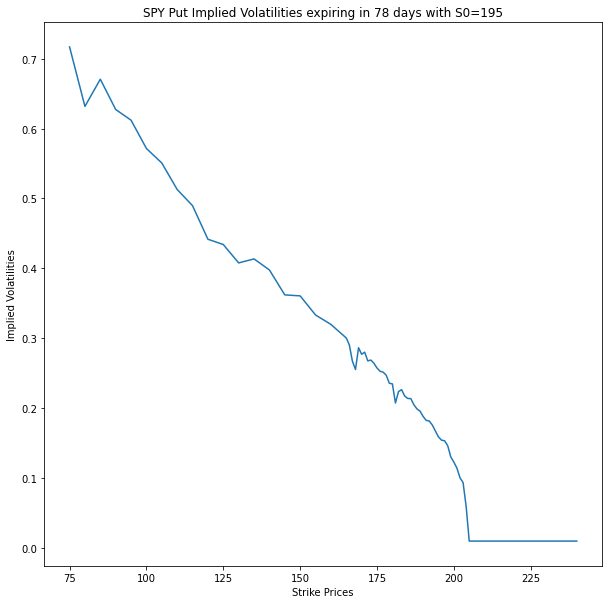

In [92]:
%matplotlib inline
import matplotlib.pyplot as plt

figure(figsize=(10,10))
plt.plot(strikes, impvols_put)
plt.xlabel('Strike Prices')
plt.ylabel('Implied Volatilities')
plt.title(f'SPY Put Implied Volatilities expiring in 78 days with S0={S0}')
plt.savefig("putsm.png")
plt.show()